In [1]:
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(palette="bright")
import tqdm

import jax.numpy as np
from jax import random, lax
from jax.config import config; config.update("jax_platform_name", "cpu")
from jax.scipy.special import logsumexp
from jax.tree_util import tree_map, tree_multimap

import numpyro.distributions as dist
from numpyro.handlers import sample
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import hmc
from numpyro.util import fori_collect

In [2]:
from jax import core, jit

In [3]:
d = np.zeros(2)
def f(c, a):
    assert a.shape == (3,)
    assert c.shape == (4,)
    b = np.sum(np.sin(a)) + np.sum(np.sin(c)) + np.sum(np.sin(d))
    c = np.sin(c * b)
    assert b.shape == ()
    return core.pack((c, b))

as_ = np.ones((5, 3))
c = np.ones(4)

ans = lax.scan(f, c, as_)

TypeError: object.__init__() takes no parameters

In [9]:
lax.scan(lambda x, y: x + y, np.ones(3), np.ones(10))

TypeError: 'ShapedArray' object is not iterable

In [2]:
num_categories = 3
num_words = 10
num_supervised_data = 100
num_unsupervised_data = 500
rng = random.PRNGKey(1)
rng, rng_transition, rng_emission = random.split(rng, 3)

transition_prior = np.ones(num_categories)
emission_prior = np.repeat(0.1, num_words)

transition_prob = dist.dirichlet.rvs(transition_prior, num_categories, random_state=rng_transition)
emission_prob = dist.dirichlet.rvs(emission_prior, num_categories, random_state=rng_emission)

In [3]:
# simulate data
start_prob = np.repeat(1. / num_categories, num_categories)
categories, words = [], []
for t in range(num_supervised_data + num_unsupervised_data):
    rng, rng_transition, rng_emission = random.split(rng, 3)
    if t == 0 or t == num_supervised_data:
        category = dist.categorical.rvs(start_prob, random_state=rng_transition)
    else:
        category = dist.categorical.rvs(transition_prob[category], random_state=rng_transition)
    word = dist.categorical.rvs(emission_prob[category], random_state=rng_emission)
    categories.append(category)
    words.append(word)
categories, words = np.stack(categories), np.stack(words)

# split into supervised data and unsupervised data
supervised_categories = categories[:num_supervised_data]
supervised_words = categories[:num_supervised_data]
unsupervised_words = categories[num_supervised_data:]

In [4]:
num_warmup_steps = num_samples = 100

### NumPyro

In [5]:
def forward_log_prob(prev_log_prob, curr_word, transition_log_prob, emission_log_prob):
    log_prob = np.expand_dims(prev_log_prob, axis=1) + transition_log_prob
    log_prob = log_prob + emission_log_prob[:, curr_word]
    return logsumexp(log_prob, axis=0)

def semi_supervised_hmm(supervised_categories, supervised_words, unsupervised_words):
    transition_prob = sample("transition_prob", dist.dirichlet(
        np.broadcast_to(transition_prior, (num_categories, num_categories))))
    emission_prob = sample("emission_prob", dist.dirichlet(
        np.broadcast_to(emission_prior, (num_categories, num_words))))

    sample("supervised_categories", dist.categorical(transition_prob[supervised_categories[:-1]]),
           obs=supervised_categories[1:])
    sample("supervised_words", dist.categorical(emission_prob[supervised_categories]),
           obs=supervised_words)

    transition_log_prob = np.log(transition_prob)
    emission_log_prob = np.log(emission_prob)
    log_prob = emission_log_prob[:, unsupervised_words[0]]
    # TODO: to be replaced by lax.scan when its jvp rule is implemented
    for t in range(1, len(unsupervised_words)):
        log_prob = forward_log_prob(log_prob, unsupervised_words[t],
                                    transition_log_prob, emission_log_prob)
    # inject log_prob to potential function
    return sample("forward_log_prob", dist.multinomial(1, log_prob, is_logits=True), obs=np.ones(1))

In [6]:
init_params, potential_fn, transform_fn = initialize_model(
    random.PRNGKey(2), semi_supervised_hmm,
    (supervised_categories, supervised_words, unsupervised_words), {})
init_kernel, sample_kernel = hmc(potential_fn, algo="NUTS")

hmc_state, wa_state, warmup_update = init_kernel(init_params, num_warmup_steps, run_warmup=False)

In [7]:
start = time.time()
warmup_update(0, (hmc_state.update(step_size=10.), wa_state))
print("time to compile sample_kernel and wa_update:", time.time() - start)

time to compile sample_kernel and wa_update: 437.1183590888977


In [8]:
for t in tqdm.trange(num_warmup_steps):
    hmc_state, wa_state = warmup_update(t, (hmc_state, wa_state))

100%|██████████| 100/100 [23:24<00:00, 11.59s/it]


In [9]:
hmc_states = fori_collect(num_samples, sample_kernel, hmc_state,
                          transform=lambda state: {
                              "transition_prob": transform_fn(state.z)["transition_prob"],
                              "num_steps": state.num_steps,
                          },
                          use_prims=False)

100%|██████████| 100/100 [18:00<00:00, 21.70s/it]


In [10]:
print(hmc_states["num_steps"].copy())

[ 447  191  127 1023  255 1023 1023  191  703  383  511  255  255 1023
  255  127  383  127 1023  238 1023  511  127  255 1023  383   83   63
  895   63  127  191   63  959 1023  383  191 1023 1023  191  127  127
 1023 1023  127  383  831 1023  127  511  127 1023  191  127  127  127
  273  511 1023  191  180  194 1023 1023   63  127   63  959 1023  319
 1023  255 1023 1023  319  127  383  511  127  511  441   95  291 1023
 1023  191  191 1023  193  127   97  383  511 1023 1023 1023   63 1023
 1023 1023]


### Stan

In [11]:
import pystan

# Source: https://github.com/stan-dev/example-models/blob/master/misc/hmm/hmm-semisup.stan
stan_model = """
data {
  int<lower=1> K;  // num categories
  int<lower=1> V;  // num words
  int<lower=0> T;  // num supervised items
  int<lower=1> T_unsup;  // num unsupervised items
  int<lower=1,upper=V> w[T];  // words
  int<lower=1,upper=K> z[T];  // categories
  int<lower=1,upper=V> u[T_unsup];  // unsup words
  vector<lower=0>[K] alpha;   // transit prior
  vector<lower=0>[V] beta;    // emit prior
}
parameters {
  simplex[K] theta[K];  // transit probs
  simplex[V] phi[K];    // emit probs
}
model {
  for (k in 1:K) 
    theta[k] ~ dirichlet(alpha);
  for (k in 1:K)
    phi[k] ~ dirichlet(beta);
  for (t in 1:T)
    w[t] ~ categorical(phi[z[t]]);
  for (t in 2:T)
    z[t] ~ categorical(theta[z[t - 1]]);

  { 
    real acc[K];
    real gamma[T_unsup, K];
    for (k in 1:K)
      gamma[1, k] <- log(phi[k, u[1]]);
    for (t in 2:T_unsup) {
      for (k in 1:K) {
        for (j in 1:K)
          acc[j] <- gamma[t-1, j] + log(theta[j, k]) + log(phi[k, u[t]]);
        gamma[t, k] <- log_sum_exp(acc);
      }
    }
    target += log_sum_exp(gamma[T_unsup]);
  }
}
"""

In [12]:
%%time
model = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e47c60e83cb8bf11dec4a8d2f9961cba NOW.


CPU times: user 935 ms, sys: 100 ms, total: 1.04 s
Wall time: 36.9 s


In [13]:
%%time
data = {"K": num_categories, "V": num_words, "T": num_supervised_data,
        "T_unsup": num_unsupervised_data, "alpha": transition_prior, "beta": emission_prior,
        "w": supervised_words + 1, "z": supervised_categories + 1, "u": unsupervised_words + 1}
fit = model.sampling(data, chains=1, iter=(num_warmup_steps + num_samples), warmup=num_warmup_steps)

CPU times: user 30.1 s, sys: 131 ms, total: 30.3 s
Wall time: 30.3 s


In [14]:
fit.get_sampler_params()[0]["n_leapfrog__"][num_warmup_steps:]

array([255., 255., 255., 511., 255., 255., 255., 255., 226., 184., 255.,
       255., 127., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
       255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
       127., 255., 255., 255., 255., 127., 255., 255., 255., 127., 127.,
       255., 255., 127., 255., 255., 255., 255., 255., 255., 383., 255.,
       511., 255., 255., 255., 511.,  79., 255., 511., 511., 179., 127.,
       127.,  43.,  61., 255., 255., 255., 255., 511., 255., 255., 255.,
       255., 255., 255., 255., 149., 255., 255., 255., 255., 185., 351.,
       255., 248., 255., 255., 255., 255., 511., 255., 255., 255., 255.,
       511.])

### Plot

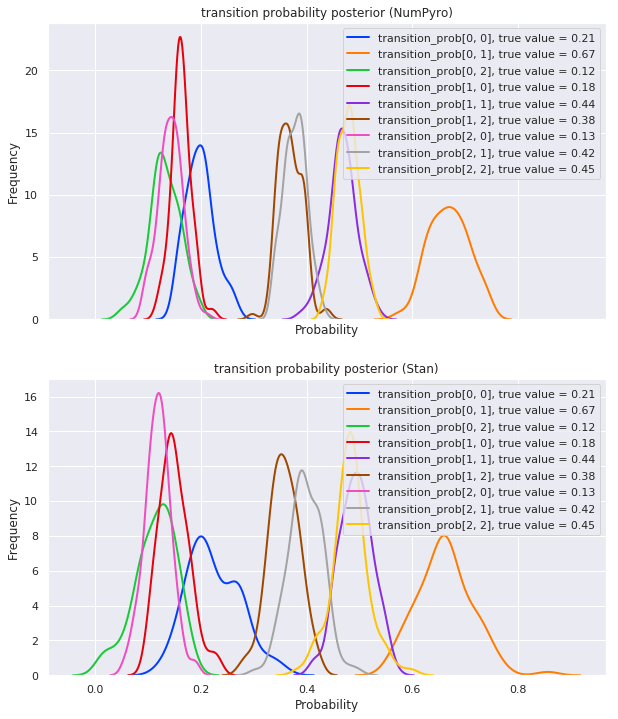

In [15]:
def plot(ax, transition_prob_posterior, title):
    for i in range(num_categories):
        for j in range(num_categories):
            sns.distplot(transition_prob_posterior[:, i, j], hist=False, kde_kws={"lw": 2},
                         label="transition_prob[{}, {}], true value = {:.2f}"
                         .format(i, j, transition_prob[i, j]), ax=ax)
    ax.set(xlabel="Probability", ylabel="Frequency",
           title="transition probability posterior ({})".format(title))

_, (ax1, ax2) = plt.subplots(2, figsize=(10, 12), sharex=True)
plot(ax1, hmc_states["transition_prob"], "NumPyro")
plot(ax2, np.array(fit.extract(pars="theta")["theta"]), "Stan")